# Assignment 12 - Viraj Noorithaya


## Script Parameters


In [1]:
# Alert: Change these when running in production
# Where are you running this? Can be either 'local' or 'colab'
# model_run_location = "colab" if "google.colab" in str(get_ipython()) else "local"
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
repo_name = "era-v1"
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "development"

# WHich branch are you working on?
branch_name = "week-12" if code_mode == "development" else "main"
folder_name = "Session 12/Submission"

## Code Procurement


In [2]:
import sys
import os

# Current working directory
print(f"CWD: {os.getcwd()}")

# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

    # Make custom modules available
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: d:\Root\Personal\WorkSpace\era-v1\Session 12\Submission


## Library Installation (Optional)


In [3]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    # Run this cell if you are using colab or local machine
    import sys
    # https://lightning.ai/docs/pytorch/stable/
    !{sys.executable} -m pip install -q lightning
    # https://github.com/davidtvs/pytorch-lr-finder
    !{sys.executable} -m pip install -q torch-lr-finder
    # https://github.com/tyleryep/torchinfo
    !{sys.executable} -m pip install -q torchinfo
    # https://github.com/jacobgil/pytorch-grad-cam
    !{sys.executable} -m pip install -q grad-cam
    # https://www.gradio.app/
    !{sys.executable} -m pip install -q gradio
    # https://github.com/tensorflow/tensorboard
    !{sys.executable} -m pip install -q tensorboard


    # Needed in local machine only
    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations
        %conda install --yes --prefix {sys.prefix} -c conda-forge tensorboard


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import matplotlib.pyplot as plt
import torch
from lightning_fabric.utilities.seed import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
import tensorboard
from tqdm.auto import tqdm

In [5]:
if code_mode == "development":
    %load_ext autoreload
    %autoreload 2

# Import user defined modules
import modules.config as config
from models.custom_resnet import CustomResNet as Net
from models.custom_resnet import detailed_model_summary
from modules.dataset import CIFAR_CLASSES
from modules.lightning_dataset import CIFARDataModule
from modules.trainer import train_and_test_model
from modules.utils import get_num_workers, pretty_print_metrics
from modules.visualize import (
    plot_gradcam_images,
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [6]:
# Alert: Change these when running in production in modules.config.py:

# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Where do we store the data, checkpoint and logging paths?
data_path = config.DATA_PATH
checkpoint_path = config.CHECKPOINT_PATH
logging_path = config.LOGGING_PATH

# Specify the number of epochs
num_epochs = config.NUM_EPOCHS

# Set the batch size
batch_size = config.BATCH_SIZE

# Set seed value for reproducibility
seed = config.SEED

## Workers and Options


In [7]:
# How many workers do you need?
num_workers = get_num_workers(model_run_location)

# https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
torch.set_float32_matmul_precision("medium")

print(
    f"Run location: {model_run_location}, \n",
    f"Number of workers: {num_workers}, \n",
    f"Batch size: {batch_size} \n",
    f"Seed: {seed} \n",
    f"Data path: {data_path} \n",
    f"Logging path: {logging_path} \n",
    f"Checkpoint path: {checkpoint_path}",
)

Run location: local, 
 Number of workers: 0, 
 Batch size: 512 
 Seed: 26 
 Data path: ../../data/ 
 Logging path: ../../logs/ 
 Checkpoint path: ../../checkpoints/


### Reproducibility settings


In [8]:
# # For reproducibility
# # https://pytorch.org/docs/stable/notes/randomness.html
# # https://github.com/pytorch/pytorch/issues/7068
# import random
# import numpy as np

# torch.manual_seed(seed)
# random.seed(seed)
# np.random.seed(seed)

# if device_support == "cuda":
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

seed_everything(seed)

Global seed set to 26


26

## Dataloaders/ Datamodule


In [9]:
# Get the data module
cifar_data_module = CIFARDataModule(data_path=data_path, batch_size=batch_size, seed=seed, num_workers=num_workers)
# cifar_data_module = CIFARDataModule(data_path=data_path, batch_size=batch_size, seed=seed, num_workers=0)
cifar_data_module.prepare_data()
cifar_data_module.setup()

# Extract the train and test dataloaders
# train_loader = cifar_data_module.training_dataset
# val_loader = cifar_data_module.validation_dataset
# test_loader = cifar_data_module.testing_dataset

train_loader = cifar_data_module.train_dataloader()
val_loader = cifar_data_module.val_dataloader()
test_loader = cifar_data_module.test_dataloader()

# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(f"Class Labels: {classes}")

Files already downloaded and verified
Files already downloaded and verified
Class Labels: ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


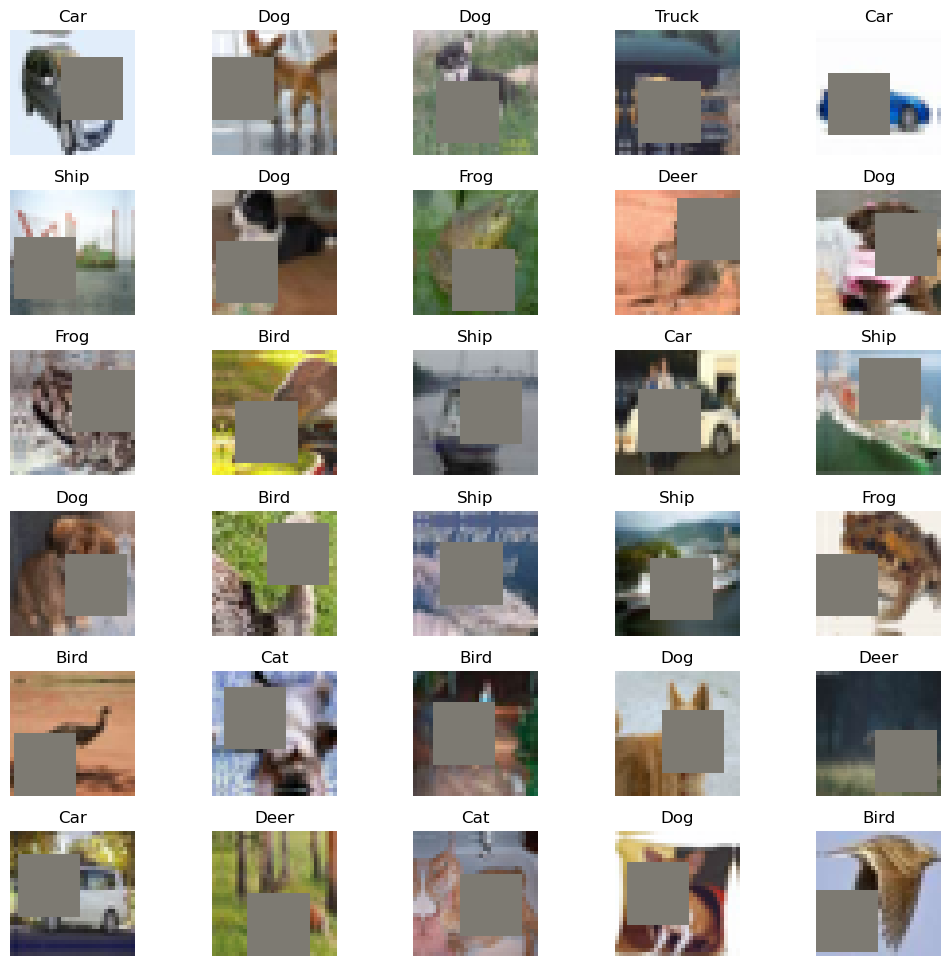

In [10]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(batch_data, batch_label, class_label=classes, num_images=30)
plt.show()

## Model Summary


In [11]:
# Define the model
# No need to send the model to device as we are using the LightningModule
model = Net()

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
	 torch.Size([1, 64, 32, 32]) 

Layer 1, X 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, X + R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 2 
	 torch.Size([1, 256, 8, 8]) 

Layer 3, X 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, R2 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, X + R2 
	 torch.Size([1, 512, 4, 4]) 

Max Pooling 
	 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
	 torch.Size([1, 512]) 

After FC 
	 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
CustomResNet                             [1, 3, 32, 32]   --               [1, 10]          --               True
├─Sequential: 1-1                        [1, 3, 32, 32]   --               [1, 64, 32, 32]  --               True
│    └─Conv2d: 2-1                       [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]  

## Train and Test


### Define Logger


In [12]:
# Define logger
# https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.TensorBoardLogger.html
logger = TensorBoardLogger(save_dir=logging_path, name="lightning_logs", log_graph=False)
# logger = CSVLogger(save_dir=logging_path, name="lightning_logs")

### Train and test model


In [13]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for num_epochs
trainer, results, misclassified_image_data = train_and_test_model(
    batch_size=batch_size,
    num_epochs=num_epochs,
    model=model,
    datamodule=cifar_data_module,
    logger=logger,
    # Alert: Change this when running in production
    debug=False,
)

d:\Apps\Anaconda3\envs\era-v1\Lib\site-packages\lightning_fabric\connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.




Batch size: 512, Total epochs: 24




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


d:\Apps\Anaconda3\envs\era-v1\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory D:\Root\Personal\WorkSpace\era-v1\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
d:\Apps\Anaconda3\envs\era-v1\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
d:\Apps\Anaconda3\envs\era-v1\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottlen

Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

d:\Apps\Anaconda3\envs\era-v1\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
LR finder stopped early after 4 steps due to diverging loss.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Restoring states from the checkpoint path at d:\Root\Personal\WorkSpace\era-v1\Session 12\Submission\.lr_find_b0d692cf-ebaf-4ede-8160-ca6cba7e20fc.ckpt
Restored all states from the checkpoint at d:\Root\Personal\WorkSpace\er

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Apps\Anaconda3\envs\era-v1\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             91.93000030517578
        test_loss           0.2675972282886505
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Metrics


In [14]:
# print(type(results))
# print(results)
# print(results.keys())
# print(results["train_loss"])

Plotting accuracy and loss graphs.


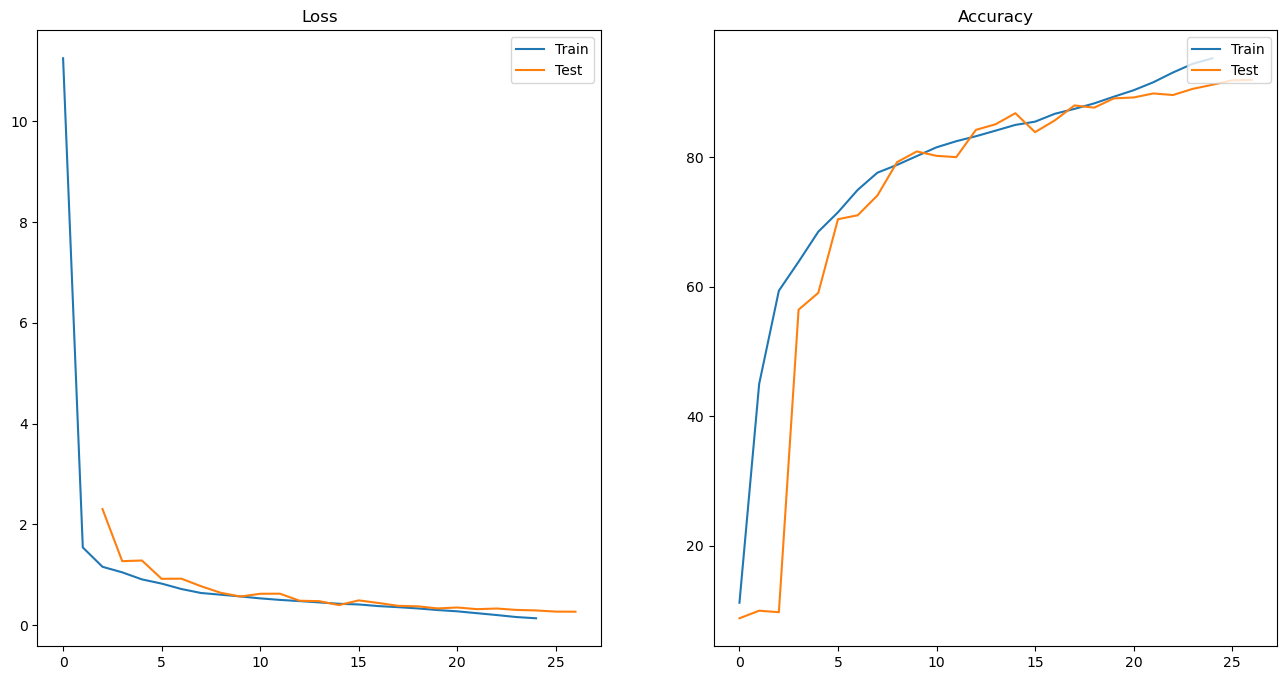

In [15]:
# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
# plt.savefig("Loss and Accuracy Metrics.png")

In [16]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=num_epochs, results=results)

Epoch: 01, Train Loss: 11.2511, Test Loss: 2.3050, Train Accuracy: 11.2305, Test Accuracy: 8.8300
Epoch: 02, Train Loss: 1.5432, Test Loss: nan, Train Accuracy: 45.0040, Test Accuracy: 10.0000
Epoch: 03, Train Loss: 1.1591, Test Loss: 2.3046, Train Accuracy: 59.3920, Test Accuracy: 9.7656
Epoch: 04, Train Loss: 1.0490, Test Loss: 1.2709, Train Accuracy: 63.8580, Test Accuracy: 56.4600
Epoch: 05, Train Loss: 0.9092, Test Loss: 1.2841, Train Accuracy: 68.5000, Test Accuracy: 59.0600
Epoch: 06, Train Loss: 0.8256, Test Loss: 0.9203, Train Accuracy: 71.4980, Test Accuracy: 70.4300
Epoch: 07, Train Loss: 0.7183, Test Loss: 0.9231, Train Accuracy: 74.9580, Test Accuracy: 71.0400
Epoch: 08, Train Loss: 0.6390, Test Loss: 0.7736, Train Accuracy: 77.6100, Test Accuracy: 74.0900
Epoch: 09, Train Loss: 0.6050, Test Loss: 0.6432, Train Accuracy: 78.8160, Test Accuracy: 79.2400
Epoch: 10, Train Loss: 0.5708, Test Loss: 0.5689, Train Accuracy: 80.1780, Test Accuracy: 80.8900
Epoch: 11, Train Loss: 0

## Show Misclassified images


In [34]:
# model.store_misclassified_images()
# misclassified_image_data = model.misclassified_image_data

# print(type(misclassified_image_data))
# print(len(misclassified_image_data))
# print(misclassified_image_data.keys())
# print(misclassified_image_data["ground_truths"][0:5])
# print(misclassified_image_data["predicted_vals"][0:5])

<class 'dict'>
3
dict_keys(['images', 'ground_truths', 'predicted_vals'])
[tensor(5), tensor(2), tensor(9), tensor(7), tensor(4)]
[tensor(2), tensor(3), tensor(8), tensor(5), tensor(5)]


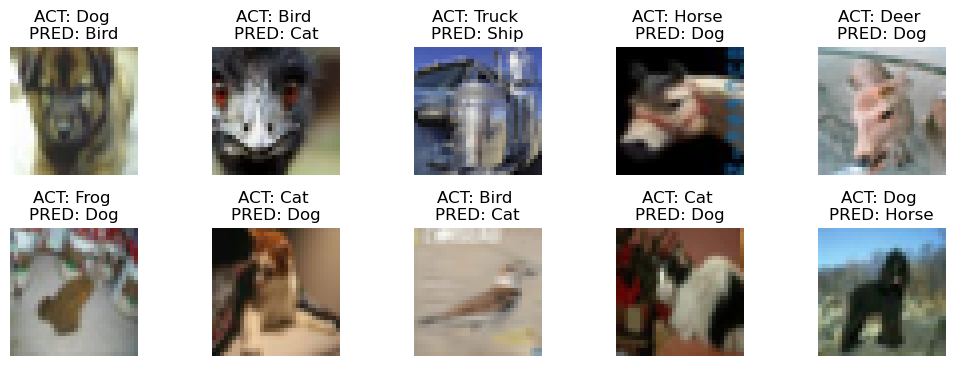

In [35]:
# Plot misclassified images
fig, axs = plot_misclassified_images(data=misclassified_image_data, class_label=classes, num_images=10)
plt.show()
# plt.savefig("Misclassified Images.png")

## GradCAM (Misclassified)


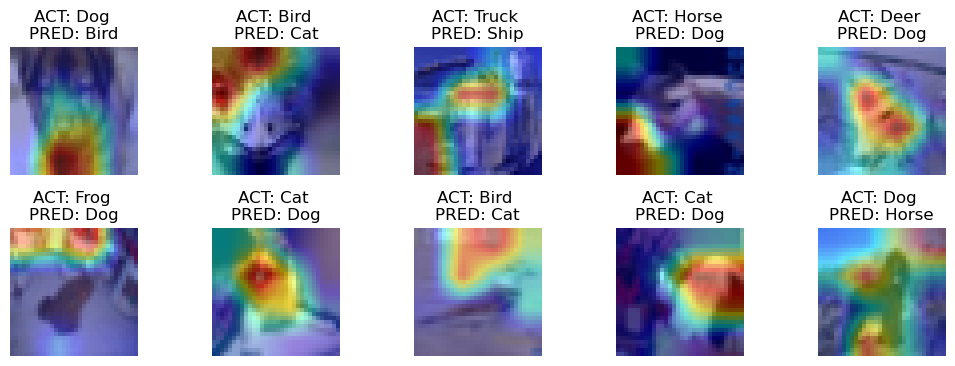

In [41]:
# Plot misclassified images
fig, axs = plot_gradcam_images(
    model=model,
    data=misclassified_image_data,
    class_label=classes,
    # Use penultimate block of resnet18 layer 3 as the target layer for gradcam
    # Decided using model summary so that dimensions > 7x7
    target_layers=[model.layer3_r2[-1]],
    targets=None,
    num_images=10,
    image_weight=0.6,
)
plt.show()
# plt.savefig("GradCAM Images.png")

## Logs


In [ ]:
# Using trainer and tensorboard logger, show the model metrics in tensorboard
%load_ext tensorboard

!tensorboard --logdir {logging_path}